# Verify the weight of V+ FFNN(can not show the power of quantum)

## Prepare environment and  define parameters 

In [1]:
is_colab = False
import sys
if is_colab:
    !pip install -q torch==1.8.1
    !pip install -q torchvision==0.4.0
    !pip install -q qiskit==0.14.0
    !pip install qfnn

import torch
import torchvision

import qiskit
from qiskit import  QuantumCircuit, ClassicalRegister
import numpy as np
import functools

In [2]:
sys.path.append('../')
from src.qfnn.qf_fb.q_output import fire_ibmq,analyze,add_measure
from src.qfnn.qf_circ.u_lyr_circ import U_LYR_Circ
from src.qfnn.qf_circ.v_lyr_circ import V_LYR_Circ
from src.qfnn.qf_net.utils import binarize
from src.qfnn.qf_fb.c_input import load_data,to_quantum_matrix

print = functools.partial(print, flush=True)



################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
ori_img_size = 28
img_size = 4
num_workers = 0 # number of subprocesses to use for data loading
batch_size = 32# how many samples per batch to load
inference_batch_size = 1
isppd = False #is prepared data

################ Zhirui on 12-30-2020 ################
# path
######################################################
if is_colab:
    data_path = '/content/data' #mnist  path
    resume_path = '/content/libs/best_model/u_v.tar' #model path
else:
    data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data' #mnist  path
    resume_path = '/home/hzr/Software/quantum/JQuantumFlow_tutorial/model/u4_v2/model_best.tar' #model path

## Load data

In [3]:
################ Zhirui on 12-30-2020 ################
# load data.
######################################################

train_loader, test_loader = load_data(interest_num,data_path,isppd,img_size,batch_size,inference_batch_size,False)
for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    break

Batch Id: 0, Target: tensor([0])


## u-layer Inference

In [4]:


# Model initialization

checkpoint = torch.load(resume_path, map_location='cpu')

weight = checkpoint['state_dict']['fc0.weight']
theta = checkpoint['state_dict']['fc2.theta']
# print(checkpoint['state_dict'])




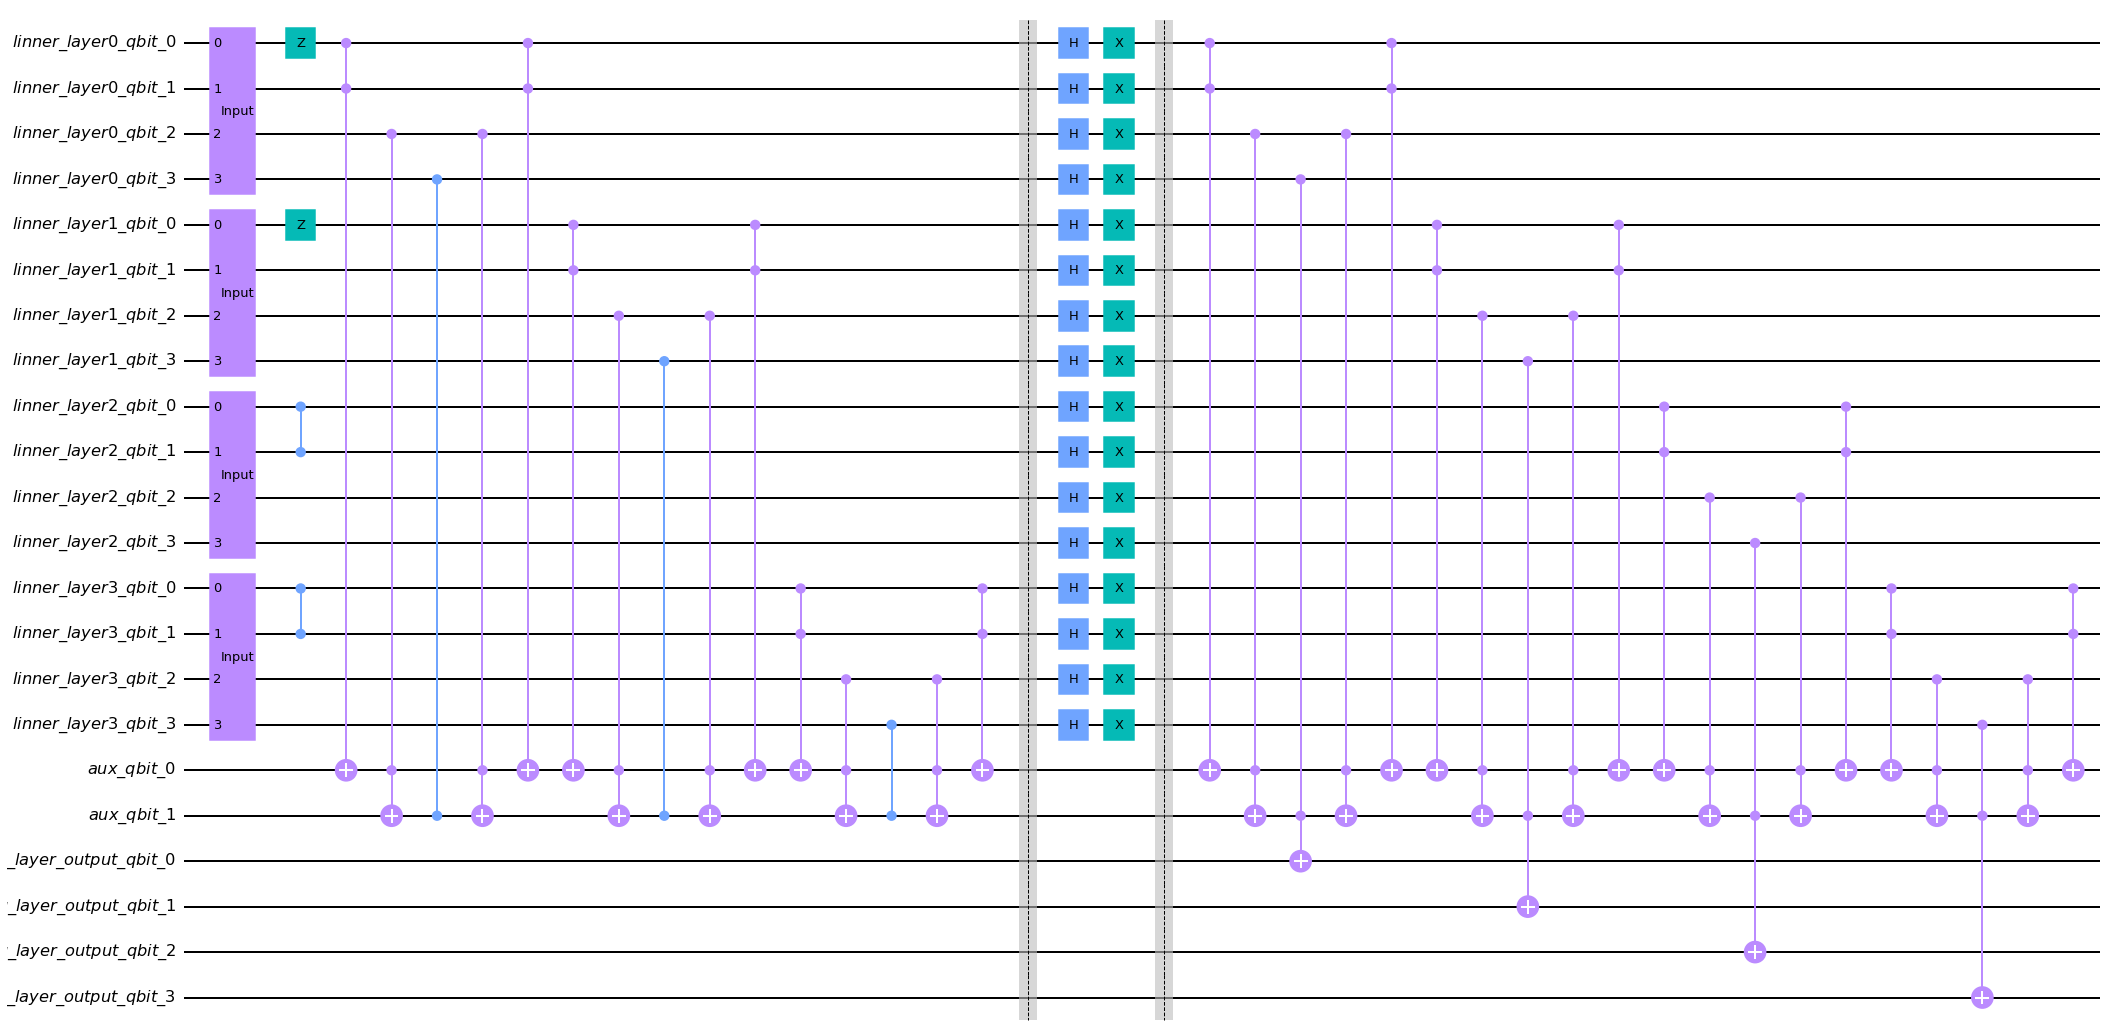

In [5]:
################ Weiwen on 12-30-2020 ################
# Generate the circuit of u-layer
######################################################

#define your input and output number
u_layer = U_LYR_Circ(4,4) 
#init circuit
circuit = QuantumCircuit()
#add input qubit to your circuit
inps = u_layer.add_input_qubits(circuit)

#add auxiliary qubit to your circuit
aux =u_layer.add_aux(circuit)

#add output qubit to your circuit
u_layer_out_qubits = u_layer.add_out_qubits(circuit)

#add ulayer to your circuit
u_layer.forward(circuit,binarize(weight),inps,u_layer_out_qubits,quantum_matrix,aux)

#show your circuit
if is_colab:
    layout = 'text'
    fold = 300
else:
    layout = 'mpl'
    fold = 50

circuit.draw(layout,fold=fold)



In [6]:
################ hzr on 12-30-2020 ################
# u-layer simulation
######################################################


circuit.barrier()
add_measure(circuit,u_layer_out_qubits,'reg')
qc_shots=10000
u_layer_counts = fire_ibmq(circuit,qc_shots,True)
print(u_layer_counts)
(u_layer_counts,u_layer_bits) = analyze(u_layer_counts)
# tensor([[8.7040e-01, 6.3164e-04, 2.4301e-02, 1.7635e-05, 2.2366e-03, 1.6231e-06,
#          6.2443e-05, 4.5315e-08, 9.9239e-02, 7.2017e-05, 2.7706e-03, 2.0106e-06,
#          2.5501e-04, 1.8506e-07, 7.1195e-06, 5.1665e-09]], dtype=torch.float64,
#        grad_fn=<TBackward>)


{'1110': 10, '0001': 8, '0110': 80, '0100': 1253, '1000': 1203, '1100': 224, '0000': 6710, '0010': 423, '1010': 89}


## v-layer inference

0 : 0.0008
1 : 0.0602
2 : 0.1567
3 : 0.1526
{'11': 204, '01': 6223, '00': 338, '10': 3235}
Result of u+v: [0.6427, 0.3439]
Prediction class: 0
Target class: 0
Correct prediction


/home/hzr/anaconda3/envs/qf/lib/python3.8/site-packages/torch/_tensor.py:645: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


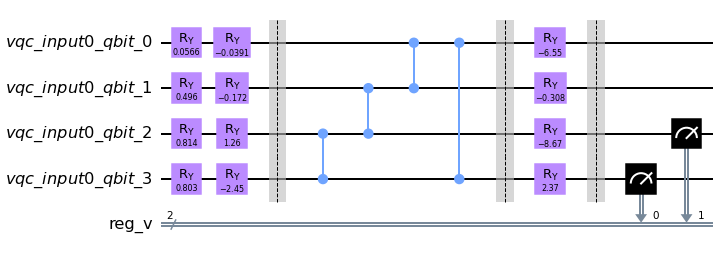

In [7]:

import math
#init new circuit
circuit2 = QuantumCircuit()
vqc = V_LYR_Circ(4,1)
v_inputs = vqc.add_input_qubits(circuit2)

#init state by u-layer-measurement
for b in range(u_layer_bits):
    prob =float(u_layer_counts[b])/qc_shots
    print(b,":",prob)

    # initial_state = [1-prob,prob]
    # initial_state = torch.tensor(initial_state,dtype=torch.cdouble)
    # initial_state = torch.sqrt(initial_state)
    # circuit2.initialize(np.array(initial_state) , b)
    circuit2.ry(2*math.asin(math.sqrt(prob)),b)

#add vqc to the circuit
vqc.forward(circuit2,v_inputs,'v10',np.array(theta,dtype=np.double))   

#add measurement to the circuit
circuit2.barrier()
add_measure(circuit2,[v_inputs[0][3],v_inputs[0][2]],'reg_v')#

opt_counts = fire_ibmq(circuit2,qc_shots,True)
print(opt_counts)
(opt_mycount,bits) = analyze(opt_counts)
opt_class_prob=[]
for b in range(2):
    opt_class_prob.append(float(opt_mycount[b])/qc_shots)
print("Result of u+v:",opt_class_prob)
print("Prediction class: {}".format(opt_class_prob.index(max(opt_class_prob))))
print("Target class: {}".format(target[0]))
if opt_class_prob.index(max(opt_class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")
print("="*30)
circuit2.draw('mpl')



In [8]:
from src.qfnn.qf_fb.c_qf_mixer import Net
from src.qfnn.qf_fb.c_input import ToQuantumData
neural_in_layers = 'u:4,p2a:16,v:2'
layers = []
for item1 in neural_in_layers.split(","):
    x= item1.split(":")
    layer =[]
    layer.append(x[0].strip())
    layer.append(int(x[1].strip()))
    layers.append(layer)

print("layers:",layers)
model = Net(img_size,layers,False,False)
model.load_state_dict(checkpoint["state_dict"])
# print(quantum_matrix)
to_quantum_data = ToQuantumData(img_size)
output_data = to_quantum_data(data)
output = model.forward(output_data,False)
print(output)

layers: [['u', 4], ['p2a', 16], ['v', 2]]
tensor([[6.7126e-01, 3.0684e-04, 4.1963e-02, 1.9182e-05, 1.2133e-01, 5.5462e-05,
         7.5850e-03, 3.4671e-06, 1.2547e-01, 5.7351e-05, 7.8434e-03, 3.5853e-06,
         2.2678e-02, 1.0366e-05, 1.4177e-03, 6.4805e-07]], dtype=torch.float64,
       grad_fn=<TBackward>)
tensor([[0.6412, 0.3460]], grad_fn=<CopyBackwards>)


/home/hzr/Software/quantum/JQuantumFlow_tutorial/tests/../src/qfnn/qf_net/utils.py:88: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/aten/src/ATen/native/Copy.cpp:240.)
  state = state.double()
